<a href="https://colab.research.google.com/github/pmeier/foo/blob/main/pystiche_PTED21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title
!pip install pystiche --no-deps &> /dev/null

import re
import warnings
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    message=(
        "The (function|parameter) logger is deprecated since pystiche==0.7.0 "
        "and will be removed in a future release. "
        "See https://github.com/pmeier/pystiche/issues/434 for details."
    ),
)
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    message=(
        re.escape(
            "Named tensors and all their associated APIs are an experimental "
            "feature and subject to change. Please do not use them for "
            "anything important until they are released as stable. (Triggered "
            "internally at  /pytorch/c10/core/TensorImpl.h:1156.)"
        )
    ),
)

import pystiche
import pystiche.enc
import pystiche.loss
import pystiche.ops
import pystiche.optim
import pystiche.demo
import pystiche.image
import torch

In [2]:
print(f"pystiche=={pystiche.__version__}")

pystiche==0.7.2.post0
torch==1.9.0+cu102


In [3]:
mle = pystiche.enc.vgg19_multi_layer_encoder()
print(mle)

VGGMultiLayerEncoder(
  arch=vgg19, framework=torch
  (preprocessing): TorchPreprocessing(
    (0): Normalize(mean=('0.485', '0.456', '0.406'), std=('0.229', '0.224', '0.225'))
  )
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_1): ReLU()
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_2): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_1): ReLU()
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_1): ReLU()
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_2): ReLU()
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3

In [4]:
content_loss = pystiche.ops.FeatureReconstructionOperator(
    mle.extract_encoder("relu4_2")
)
print(content_loss)

FeatureReconstructionOperator(
  score_weight=1,
  encoder=VGGMultiLayerEncoder(layer=relu4_2, arch=vgg19, framework=torch)
)


In [5]:
style_loss = pystiche.ops.MultiLayerEncodingOperator(
    multi_layer_encoder=mle,
    layers=("relu1_1", "relu2_1", "relu3_1", "relu4_1", "relu5_1"),
    get_encoding_op=pystiche.ops.GramOperator,
    score_weight=1e3,
)
print(style_loss)

MultiLayerEncodingOperator(
  encoder=VGGMultiLayerEncoder(arch=vgg19, framework=torch), score_weight=1000
  (relu1_1): GramOperator(score_weight=1)
  (relu2_1): GramOperator(score_weight=1)
  (relu3_1): GramOperator(score_weight=1)
  (relu4_1): GramOperator(score_weight=1)
  (relu5_1): GramOperator(score_weight=1)
)


In [6]:
perceptual_loss = pystiche.loss.PerceptualLoss(content_loss, style_loss)
perceptual_loss.cuda()
print(perceptual_loss)

PerceptualLoss(
  (content_loss): FeatureReconstructionOperator(
    score_weight=1,
    encoder=VGGMultiLayerEncoder(layer=relu4_2, arch=vgg19, framework=torch)
  )
  (style_loss): MultiLayerEncodingOperator(
    encoder=VGGMultiLayerEncoder(arch=vgg19, framework=torch), score_weight=1000
    (relu1_1): GramOperator(score_weight=1)
    (relu2_1): GramOperator(score_weight=1)
    (relu3_1): GramOperator(score_weight=1)
    (relu4_1): GramOperator(score_weight=1)
    (relu5_1): GramOperator(score_weight=1)
  )
)


In [7]:
images = pystiche.demo.images()
content_image = images["bird1"].read(size=500, device="cuda")
style_image = images["paint"].read(size=500, device="cuda")

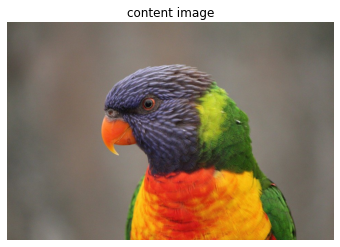

In [8]:
pystiche.image.show_image(content_image, title="content image")

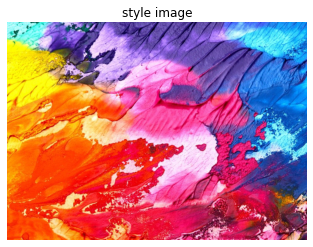

In [9]:
pystiche.image.show_image(style_image, title="style image")

In [10]:
perceptual_loss.set_content_image(content_image)
perceptual_loss.set_style_image(style_image)
starting_point = content_image.clone()

In [11]:
stylized_image = pystiche.optim.image_optimization(
    starting_point, perceptual_loss, num_steps=500, logger=pystiche.demo.logger(),
)

################################################################################
Step 50
################################################################################
  content_loss: 7.284e+00
  style_loss  : 5.127e+02
################################################################################
Step 100
################################################################################
  content_loss: 7.479e+00
  style_loss  : 1.731e+02
################################################################################
Step 150
################################################################################
  content_loss: 7.572e+00
  style_loss  : 1.068e+02
################################################################################
Step 200
################################################################################
  content_loss: 7.601e+00
  style_loss  : 7.604e+01
################################################################################
Step 250
###################

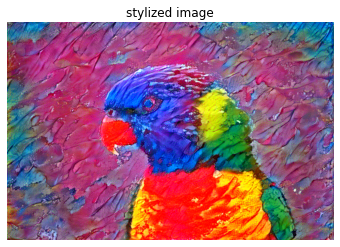

In [12]:
pystiche.image.show_image(stylized_image, title="stylized image")